# 13 Nov 23 - Notes: Applications of FFTs

As you have learned, we can use the Fourier Transform to decompose a signal into its frequency components. This is useful for many applications, including filtering, noise removal, and compression. All of these rely on some reconstruction of the original signal from the frequency components. 

While this might not seem like a big deal, it is quite powerful, if we realize that we can also manipulate the frequency components before reconstructing the signal. This is the basis of many signal processing techniques. We will use this reading to highlight two common examples of data in physics where FFTs are used: time series and images. Let's start by importing our libraries.

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft, fft2, ifft2, fftshift
import numpy as np
import IPython.display as ipd
from PIL import Image

## Time series

The waves we had studied thus far could have been generated in a way that produces a ['time series'](https://en.wikipedia.org/wiki/Time_series) data set. There are many examples of such data sets. One of the most comprehensive and free archives (thanks to UK tax payers) is the [BBC's sound effects archive](https://sound-effects.bbcrewind.co.uk/). The sound below is from the bells at [St. Michael's Church](https://sound-effects.bbcrewind.co.uk/search?q=07070175). We import it and you can play it. It's in stereo so we'll just use one channel.

In [6]:
sample_rate, data = wavfile.read('../assets/data/bells.wav')
if len(data.shape) > 1:
    data = data.mean(axis=1)
ipd.Audio(data, rate=sample_rate)

/var/folders/rh/mck_zfls1nz00lkh8jq3cpv80000gn/T/ipykernel_54134/896160428.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read('../assets/data/bells.wav')


### Visualizing the time series

We can plot the time series. You see it's a real signal with a real amplitude. 

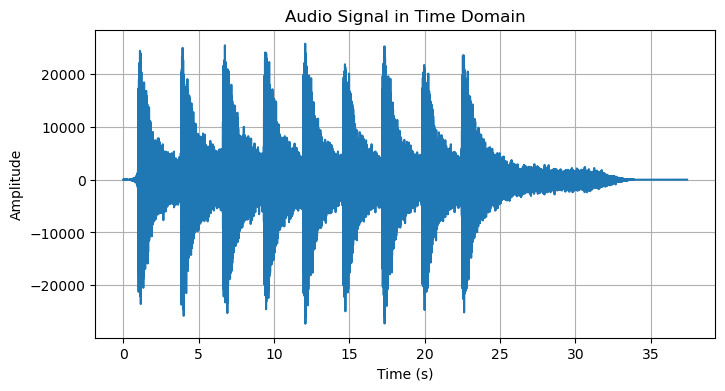

In [8]:
# Get the number of samples
num_samples = data.shape[0]

# Create a time array/scale
time = np.linspace(0, num_samples/sample_rate, num=num_samples)

# Plot the signal in the time domain
plt.figure(figsize=(8, 4))
plt.plot(time, data)  # Plot the first 1000 samples
plt.title('Audio Signal in Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

### Fast Fourier Transform and the Power Spectrum

We can use the numpy FFT function to transform the time series into the frequency domain. We can then plot the power spectrum. We have done this before, but we made the signal ourselves. How do we choose how to break down the signal? What is the $dt$?

The signal has a known sampling rate of 44.1 kHz; we get that from the imported data information. This means that the time between samples is $dt = 1/44100$ s. We use the variable `sample_rate` that we defined above to calculate this.

Here, we also compute the power spectrum. We've made the choice to sqaure the absoluate value of the FFT; this is a common choice to represent power or intensity in some situtations. We also double the FFT like before to deal with the negative frequencies. And we scale it by the sum of the spectrum, which is another choice. We have done most of this before and you can choose something else. The important thing is the relative values of the power spectrum.

In [11]:
# Calculate the two-sided power spectrum
data_fft = fft(data)
power_spectrum = np.abs(data_fft)**2

freqs = np.fft.fftfreq(len(data_fft), 1/sample_rate)

# Convert to a one-sided power spectrum by taking the first half and doubling it
one_sided_power_spectrum = power_spectrum[:num_samples//2] * 2 / np.sum(power_spectrum)
one_sided_power_spectrum[0] /= 2  # Do not double the DC component

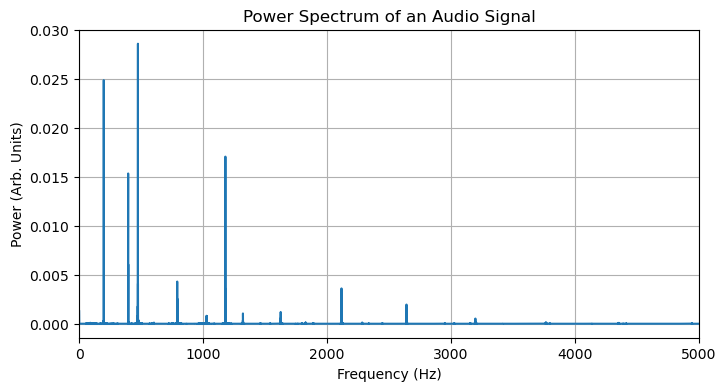

In [12]:
# Plot the normalized one-sided power spectrum
plt.figure(figsize=(8, 4))

plt.plot(freqs[:num_samples//2], one_sided_power_spectrum)
plt.xlim(0, 5000)

plt.title('Power Spectrum of an Audio Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (Arb. Units)')

plt.grid()

#### Finding the peaks

We see that we can find the frequencies of the peaks in the power spectrum. It might seem hard to pick them out. That is because the scale changes wildly. We can use a log scale to make it easier to see the peaks. Below we do that and you see many more peaks.

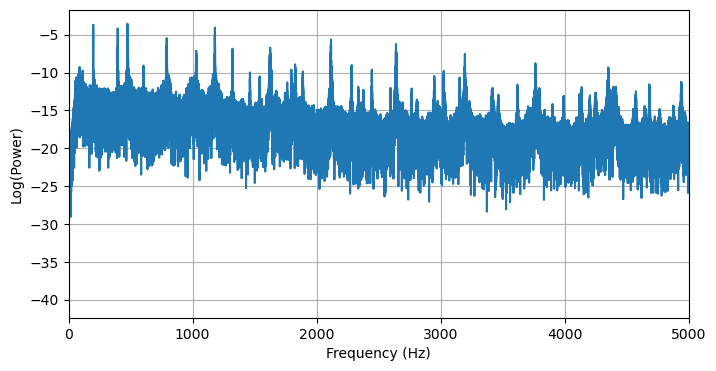

In [14]:
plt.figure(figsize=(8, 4))

plt.plot(freqs[:num_samples//2], np.log(one_sided_power_spectrum))
plt.xlim(0, 5000)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Log(Power)')

plt.grid()

**&#9989; Try this**

Look up the [`find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) function from the `scipy.signal` library and try to find the frequency peaks. Which notes are closest to the peaks?

In [10]:
## Your code here

## Images

Many physics experiments use image data to record their results. This is especially true in astronomy. We can use the FFT to analyze images. Imaging enhancement can take the form of many different techniques, but will illustrate a classic one called the Gaussian filter. For this example, we will use an image from the [Hubble Ultra Deep Field](https://en.wikipedia.org/wiki/Hubble_Deep_Field). You can see a color version below:

![Hubble Ultra Deep Field](https://images-assets.nasa.gov/image/GSFC_20171208_Archive_e001061/GSFC_20171208_Archive_e001061~small.jpg)

We can load the image as grey scale. Here the matrix represents the intensity of the light at each pixel. We can plot the image. We see that it is a bit noisy. We can use the FFT to filter out some of the noise.

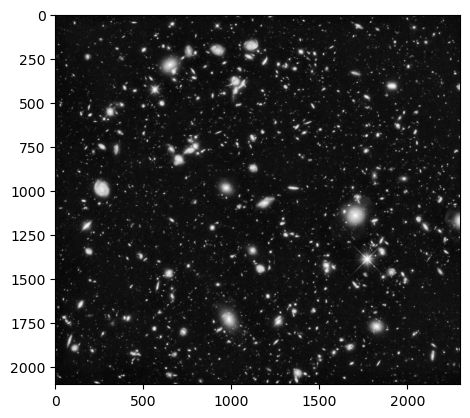

In [15]:
image = Image.open('../assets/data/hubble.jpeg').convert('L')  # Convert to grayscale
plt.imshow(image, cmap='gray')

### Reducing Noise

There are many applications of the FFT to image processing, but one is [noise reduction](https://en.wikipedia.org/wiki/Noise_reduction). We can use the FFT to filter out some of the noise. 

We will use a Gaussian filter. This is a common filter that is used in many applications. It is a [convolution](https://en.wikipedia.org/wiki/Convolution) of the image with a Gaussian function. We will use the [`gaussian_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) function from the `scipy.ndimage` library. We don't expect you to learn what this is in detail unless you start to investigate it for a project. We will just use it here.

In class, we will do this kind of work in 1 dimension to clean and filter signals. Below, we import the filter, and then proceed with the FFT for the image; we filter it; and then we transform it back to the image. We plot the original and the filtered image. You can see that the noise is reduced yielding a clearer image.

In [17]:
from scipy.ndimage import gaussian_filter

## Convert the image to a numpy array
image_array = np.array(image)

# Apply 2D FFT and shift zero frequency components to the center of the spectrum
f_transform = fftshift(fft2(image_array))

# Apply a Gaussian filter in the frequency domain for noise reduction (don't worry too much about this, we're just altering the magnitude spectrum)
f_transform_filtered = gaussian_filter(np.abs(f_transform), sigma=5) * np.exp(1j * np.angle(f_transform))

# Calculate the magnitude spectra for plotting
magnitude_spectrum = np.log(np.abs(f_transform))
filtered_magnitude_spectrum = np.log(np.abs(f_transform_filtered))

# Apply 2D inverse transform to get the noise-reduced image
image_denoised = ifft2(fftshift(f_transform_filtered)).real

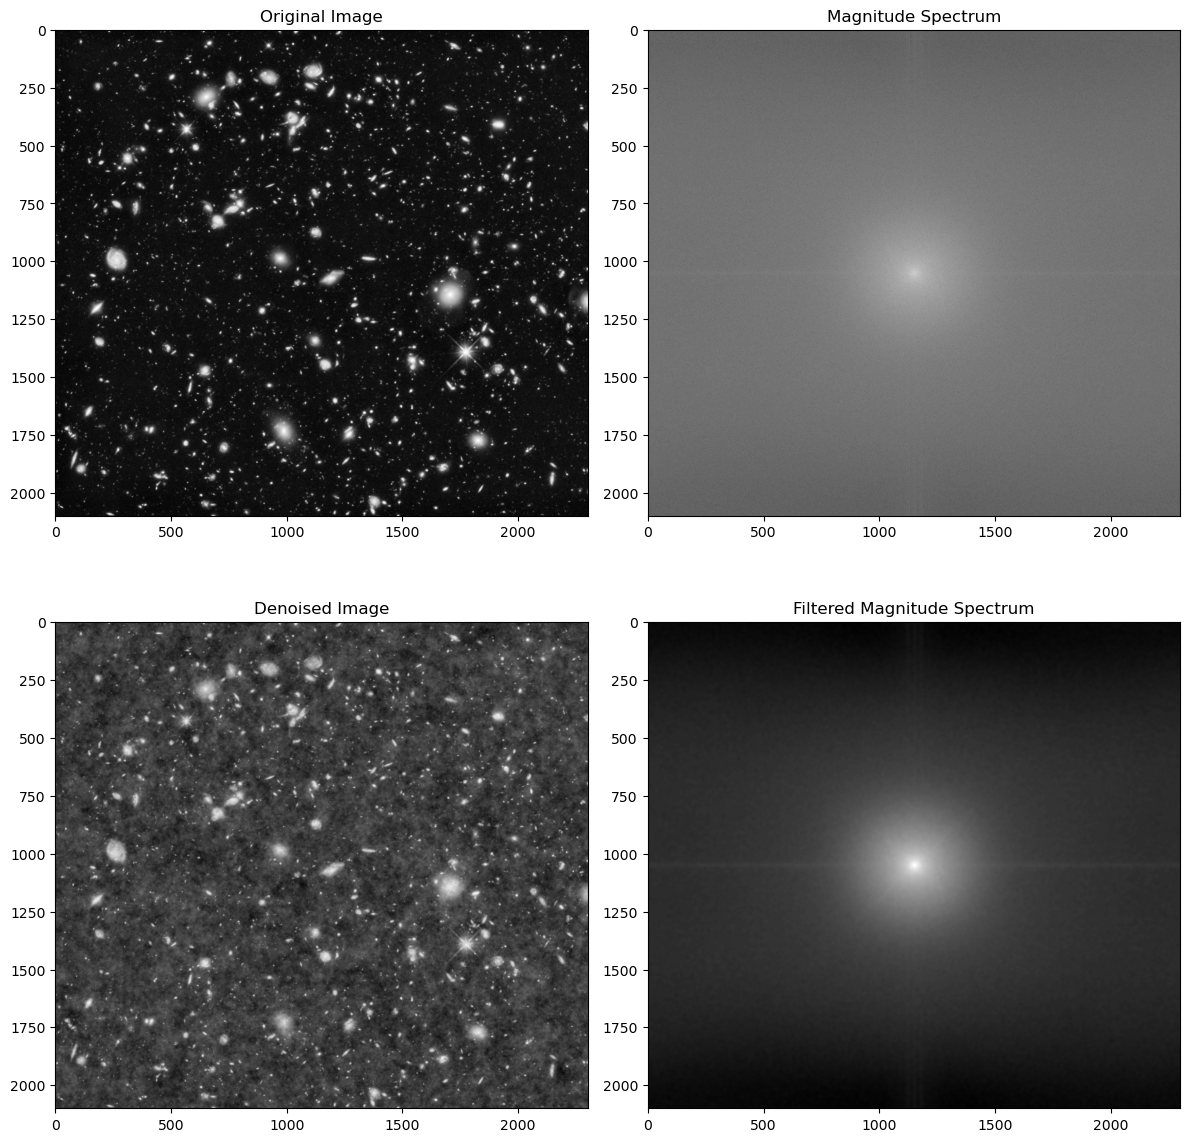

In [18]:
plt.figure(figsize=(12, 12))

plt.subplot(221), plt.imshow(image_array, cmap='gray'), plt.title('Original Image')
plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Magnitude Spectrum')
plt.subplot(223), plt.imshow(image_denoised, cmap='gray'), plt.title('Denoised Image')
plt.subplot(224), plt.imshow(filtered_magnitude_spectrum, cmap='gray'), plt.title('Filtered Magnitude Spectrum')

plt.tight_layout()

The FFT is widely useful tool. We highlight only two applications here, but there are many more. We will use the FFT in class to analyze signals and images.

